In [16]:
import pandas as pd
import numpy as np
import torch
from dataset import ClimateDatasetV2A
with open("../climate_washed/static_filtered.csv", "r") as f:
    stations = pd.read_csv(f)


In [17]:
runoffs = []
prs = []
for staid in stations['STAID']:
    staid = str(staid).zfill(8)

    with open("../climate_washed/{}.csv".format(staid), "r") as f:
        data = pd.read_csv(f)
        runoff = data["runoff"].tolist()
        # filter out nan values
        runoff = [x for x in runoff if x == x]

        pr = data["pr"].tolist()
        pr = [x for x in pr if x == x]
    runoffs.extend(runoff)
    prs.extend(pr)
runoffs = torch.tensor(runoffs)
prs = torch.tensor(prs)


In [18]:
prs[prs < 5].sum()

tensor(136749.9531)

In [19]:
x_feature = ["runoff", "pr", "sph", "srad", "tmmn", "tmmx", "pet", "etr", "ph", "Conduc", "Ca", "Mg", "K", "Na", "NH4", "NO3", "Cl", "SO4", "distNTN", "LAI", "FAPAR", "NPP", "datenum", "sinT", "cosT"]
y_feature = ["00010", "00095", "00300", "00400", "00405", "00600", "00605", "00618", "00660", "00665", "00681", "00915", "00925", "00930", "00935", "00940", "00945", "00955", "71846", "80154"]
dataset = ClimateDatasetV2A("../climate_washed", "LogMinMax", "train", None, x_feature, y_feature, location_static=True, minmax_feature=["LAI", "FAPAR", "NPP", "LAT_GAGE", "LNG_GAGE", "datenum", "sinT", "cosT"])


Station shape:  torch.Size([205105, 5])
Temporal shape:  torch.Size([205105, 69])
(205105, 20)


In [20]:
stats = dataset.get_stats()['temporal']
logmin = stats['logmin']
logmax = stats['logmax']
print(torch.log(torch.tensor(1e-4)))
pr_logmin = logmin[1]
pr_logmax = logmax[1]
runoff_logmin = logmin[0]
runoff_logmax = logmax[0]


tensor(-9.2103)


In [21]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
pr = torch.log(prs+1e-2)
runoff = torch.log(runoffs+1e-2)

pr_mean, pr_std = torch.mean(pr), torch.std(pr)
runoff_mean, runoff_std = torch.mean(runoff), torch.std(runoff)
print(pr.shape)
print(runoff.shape)

# pr_norm = (pr - pr_logmin) / (pr_logmax - pr_logmin)
# runoff_norm = (runoff - runoff_logmin) / (runoff_logmax - runoff_logmin)

# pr_norm = (pr - pr_mean) / pr_std
# runoff_norm = (runoff - runoff_mean) / runoff_std
# scaler = RobustScaler()
scaler = QuantileTransformer(output_distribution='uniform')
scaled_data1 = scaler.fit_transform(pr.numpy().reshape(-1, 1))

# 将变换后的数据转换为 PyTorch 张量
pr_norm = torch.tensor(scaled_data1, dtype=torch.float32)

scaler = QuantileTransformer(output_distribution='uniform')
scaled_data2 = scaler.fit_transform(runoff.numpy().reshape(-1, 1))

# 将变换后的数据转换为 PyTorch 张量
runoff_norm = torch.tensor(scaled_data2, dtype=torch.float32)


torch.Size([255740])
torch.Size([255740])


In [22]:
calculated_logmin = pr.min(dim=0)[0]
calculated_logmax = pr.max(dim=0)[0]
print("calculated pr logmin: ", calculated_logmin)
print("calculated pr logmax: ", calculated_logmax)
print("pr logmin: ", pr_logmin)
print("pr logmax: ", pr_logmax)

calculated pr logmin:  tensor(-4.6052)
calculated pr logmax:  tensor(5.4460)
pr logmin:  tensor(-9.2103)
pr logmax:  tensor(5.4460)


In [23]:
calculated_logmax = runoff.max(dim=0)[0]
calculated_logmin = runoff.min(dim=0)[0]
print("calculated runoff logmin: ", calculated_logmin)
print("calculated runoff logmax: ", calculated_logmax)
print("runoff logmin: ", runoff_logmin)
print("runoff logmax: ", runoff_logmax)

calculated runoff logmin:  tensor(-4.6052)
calculated runoff logmax:  tensor(4.0934)
runoff logmin:  tensor(-9.2103)
runoff logmax:  tensor(4.0932)


tensor(0.4354) tensor(0.3606)
tensor(0.4980) tensor(0.2882)


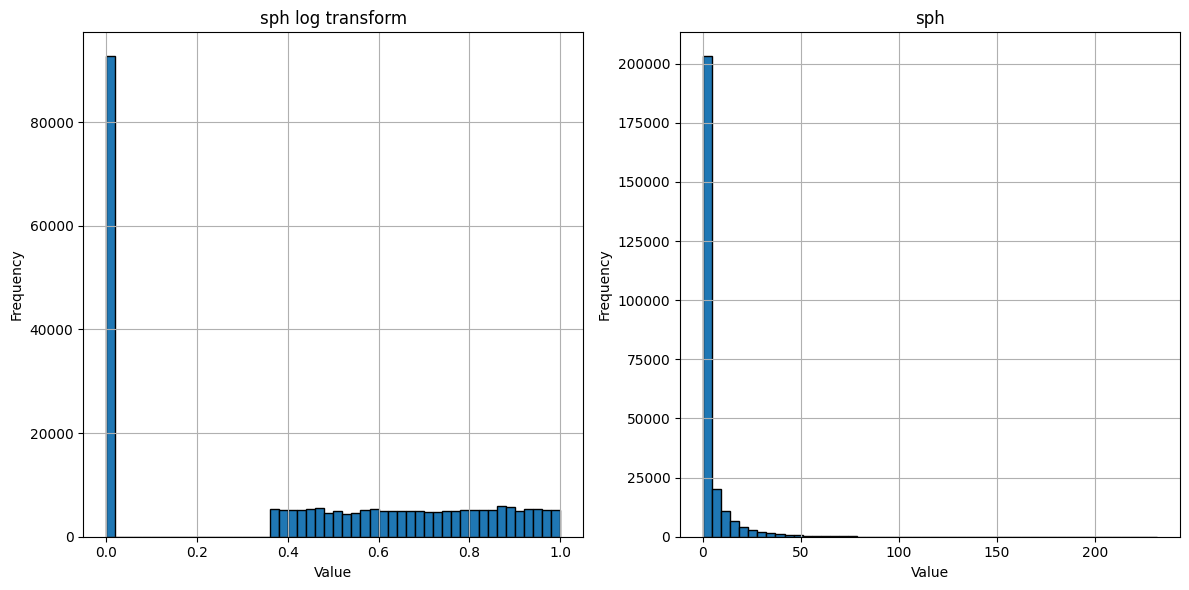

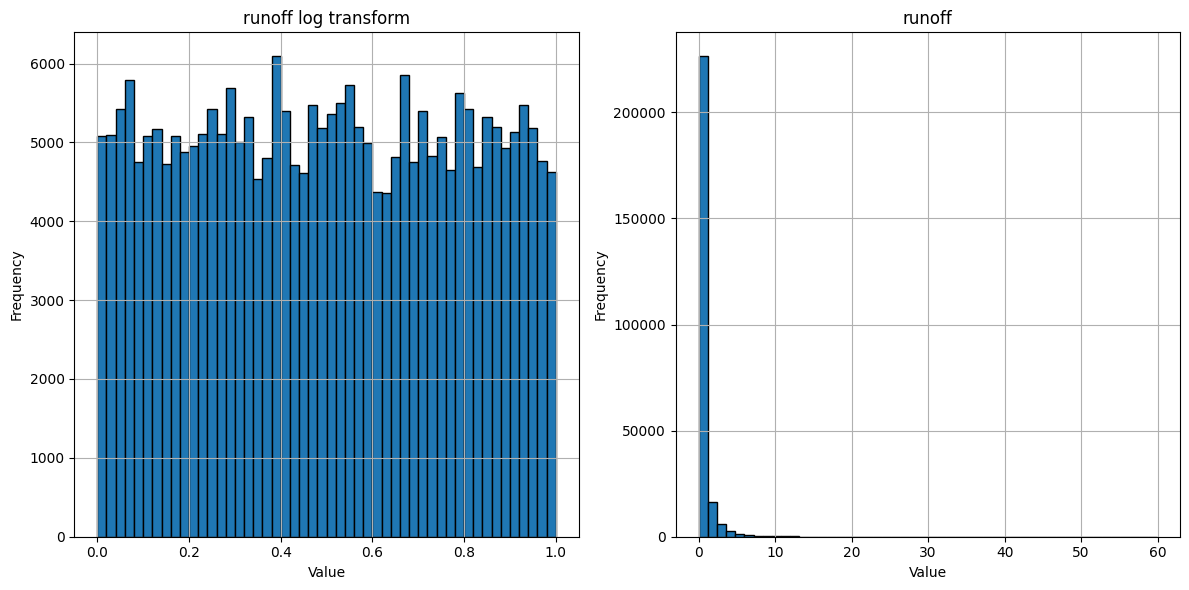

In [24]:
import matplotlib.pyplot as plt

def draw_histogram(data1, data2, bins=50, title1='Histogram 1', title2='Histogram 2', xlabel='Value', ylabel='Count'):
    """
    Draws two histograms from two 1D numpy arrays and puts them into one figure.

    Parameters:
    - data1: 1D numpy array for the first histogram
    - data2: 1D numpy array for the second histogram
    - bins: Number of bins for the histograms (default is 10)
    - title1: Title of the first histogram (default is 'Histogram 1')
    - title2: Title of the second histogram (default is 'Histogram 2')
    - xlabel: Label for the x-axis (default is 'Value')
    - ylabel: Label for the y-axis (default is 'Count')
    """
    plt.figure(figsize=(12, 6))

    # First histogram
    plt.subplot(1, 2, 1)
    plt.hist(data1, bins=bins, edgecolor='black')
    plt.title(title1)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    # Second histogram
    plt.subplot(1, 2, 2)
    plt.hist(data2, bins=bins, edgecolor='black')
    plt.title(title2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

print(torch.mean(pr_norm), torch.std(pr_norm))
print(torch.mean(runoff_norm), torch.std(runoff_norm))

draw_histogram(pr_norm.numpy(), prs.numpy(), bins=50, title1='sph log transform', title2='sph', xlabel='Value', ylabel='Frequency')
draw_histogram(runoff_norm.numpy(), runoffs.numpy(), bins=50, title1='runoff log transform', title2='runoff', xlabel='Value', ylabel='Frequency')